# Preprocessing AND Feature Engineering

In [32]:
"""
Kickstarter Project: Data Cleaning & Preprocessing

This script focuses on:
1. Handling missing values
2. Comprehensive feature engineering
3. Data leakage prevention
4. Advanced encoding techniques

The goal is to prepare the Kickstarter dataset for modeling while ensuring
no data leakage occurs and all features are properly engineered.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from datetime import datetime
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set visual style
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Loading Kickstarter dataset...")
df = pd.read_excel("/Users/jaeyoonlee/Desktop/Kickstarter.xlsx")
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

# Filter only successful and failed projects (as required)
df = df[df['state'].isin(['successful', 'failed'])]
print(f"Filtered to include only successful and failed projects: {df.shape[0]} rows")

# --------------------------------------------------------
# 1. MISSING VALUES ANALYSIS AND IMPUTATION
# --------------------------------------------------------

print("\n=== MISSING VALUES ANALYSIS ===")

# Check for missing values
missing_vals = df.isnull().sum()
print("Columns with missing values:")
print(missing_vals[missing_vals > 0])

# Calculate missing percentage
missing_percent = (df.isnull().sum() / len(df)) * 100
print("\nMissing percentage by column:")
print(missing_percent[missing_percent > 0])

# Identify columns by data type for appropriate imputation
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

# For demonstration, we'll show multiple imputation methods
# In practice, you'd choose the most appropriate one based on your analysis

# 1.1 Simple Imputation
print("\nPerforming simple imputation...")
df_simple = df.copy()

# For numeric columns: median imputation
for col in numeric_cols:
    if df_simple[col].isnull().sum() > 0:
        df_simple[col] = df_simple[col].fillna(df_simple[col].median())
        
# For categorical columns: mode imputation
for col in categorical_cols:
    if df_simple[col].isnull().sum() > 0:
        df_simple[col] = df_simple[col].fillna(df_simple[col].mode().iloc[0])

# 1.2 KNN Imputation for numeric features
print("\nPerforming KNN imputation for numeric features...")
df_knn = df.copy()

# Only use numeric columns that have missing values for KNN imputation
numeric_missing = [col for col in numeric_cols if df[col].isnull().sum() > 0]

if numeric_missing:
    # Select subset of columns for imputation
    imputer_cols = numeric_missing + ['goal']  # Include goal as a predictor
    imputer_data = df_knn[imputer_cols].copy()
    
    # Standardize before KNN imputation
    scaler = StandardScaler()
    imputer_data_scaled = scaler.fit_transform(imputer_data.fillna(imputer_data.median()))
    
    # Perform KNN imputation
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed_values = knn_imputer.fit_transform(imputer_data_scaled)
    
    # Transform back to original scale
    imputed_data = scaler.inverse_transform(imputed_values)
    
    # Replace values in original dataframe
    for i, col in enumerate(imputer_cols):
        df_knn[col] = imputed_data[:, i]
else:
    print("No missing values in numeric columns.")

# 1.3 MICE Imputation (Multiple Imputation by Chained Equations)
print("\nPerforming MICE imputation...")
df_mice = df.copy()

# Only use columns that have missing values for MICE
mice_cols = [col for col in numeric_cols if df[col].isnull().sum() > 0]

if mice_cols:
    # Select subset of columns for imputation
    imputer_data = df_mice[mice_cols + ['goal']].copy()  # Include goal as a predictor
    
    # Perform MICE imputation
    mice_imputer = IterativeImputer(max_iter=10, random_state=42)
    imputed_values = mice_imputer.fit_transform(imputer_data)
    
    # Replace values in original dataframe
    for i, col in enumerate(imputer_data.columns):
        df_mice[col] = imputed_values[:, i]
else:
    print("No missing values in columns selected for MICE.")

# Compare imputation methods (if applicable)
if numeric_missing:
    print("\nComparing imputation methods:")
    for col in numeric_missing:
        print(f"\nColumn: {col}")
        print(f"Original median: {df[col].median()}")
        print(f"Simple imputation median: {df_simple[col].median()}")
        print(f"KNN imputation median: {df_knn[col].median()}")
        print(f"MICE imputation median: {df_mice[col].median() if col in df_mice.columns else 'N/A'}")

# Using KNN imputation for our final dataset as it tends to preserve relationships
df = df_knn

# --------------------------------------------------------
# 2. FEATURE ENGINEERING
# --------------------------------------------------------

print("\n=== FEATURE ENGINEERING ===")

# 2.1 Temporal Features
print("\nCreating temporal features...")

# Parse datetime columns
date_columns = ['deadline', 'state_changed_at', 'created_at', 'launched_at']
for col in date_columns:
    if col in df.columns:
        df[f'{col}_datetime'] = pd.to_datetime(df[col])

# Calculate campaign duration (days)
df['campaign_duration'] = (df['deadline_datetime'] - df['launched_at_datetime']).dt.total_seconds() / (60*60*24)
print(f"Campaign duration statistics:\n{df['campaign_duration'].describe()}")

# Calculate preparation time (days from creation to launch)
df['preparation_time'] = (df['launched_at_datetime'] - df['created_at_datetime']).dt.total_seconds() / (60*60*24)
print(f"Preparation time statistics:\n{df['preparation_time'].describe()}")

# Extract day of week features
for col in ['deadline', 'launched_at']:
    df[f'{col}_is_weekend'] = df[f'{col}_datetime'].dt.dayofweek >= 5

# Create month, day, and hour cyclic features
for col in ['deadline', 'launched_at']:
    # Month as cyclic feature (sin and cos)
    df[f'{col}_month_sin'] = np.sin(2 * np.pi * df[f'{col}_datetime'].dt.month / 12)
    df[f'{col}_month_cos'] = np.cos(2 * np.pi * df[f'{col}_datetime'].dt.month / 12)
    
    # Day of month as cyclic feature
    day_max = 31
    df[f'{col}_day_sin'] = np.sin(2 * np.pi * df[f'{col}_datetime'].dt.day / day_max)
    df[f'{col}_day_cos'] = np.cos(2 * np.pi * df[f'{col}_datetime'].dt.day / day_max)
    
    # Hour as cyclic feature
    df[f'{col}_hour_sin'] = np.sin(2 * np.pi * df[f'{col}_datetime'].dt.hour / 24)
    df[f'{col}_hour_cos'] = np.cos(2 * np.pi * df[f'{col}_datetime'].dt.hour / 24)

# 2.2 Goal-related features
print("\nCreating goal-related features...")

# Goal per day ratio
df['goal_per_day'] = df['goal'] / df['campaign_duration']
print(f"Goal per day statistics:\n{df['goal_per_day'].describe()}")

# Goal bins (logarithmic scale for better distribution)
df['goal_log'] = np.log1p(df['goal'])  # log(1+x) to handle zeros

# Goal percentiles
goal_percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
goal_bins = np.percentile(df['goal'], goal_percentiles)
df['goal_percentile_bin'] = pd.cut(df['goal'], bins=goal_bins, labels=range(len(goal_percentiles)-1))

# 2.3 Category-based features
print("\nCreating category-based features...")

# Calculate success rates by category
category_success = df.groupby('main_category')['state'].apply(
    lambda x: (x == 'successful').mean()).to_dict()

# Map success rates back to dataframe
df['category_success_rate'] = df['main_category'].map(category_success)

# Subcategory success rates
subcategory_success = df.groupby('category')['state'].apply(
    lambda x: (x == 'successful').mean()).to_dict()
df['subcategory_success_rate'] = df['category'].map(subcategory_success)

# 2.4 Geographic features
print("\nCreating geographic features...")

# Country success rates
country_success = df.groupby('country')['state'].apply(
    lambda x: (x == 'successful').mean()).to_dict()
df['country_success_rate'] = df['country'].map(country_success)

# Country project counts (as a proxy for platform maturity in that region)
country_counts = df.groupby('country').size().to_dict()
df['country_project_count'] = df['country'].map(country_counts)

# Currency features
currency_success = df.groupby('currency')['state'].apply(
    lambda x: (x == 'successful').mean()).to_dict()
df['currency_success_rate'] = df['currency'].map(currency_success)

# 2.5 Text-based features
print("\nCreating text-based features...")

# Name-to-blurb ratio (proportion of name length to blurb length)
df['name_blurb_ratio'] = df['name_len'] / df['blurb_len']

# Length efficiency (clean vs. total length)
df['name_efficiency'] = df['name_len_clean'] / df['name_len']
df['blurb_efficiency'] = df['blurb_len_clean'] / df['blurb_len']

# 2.6 Additional features
print("\nCreating additional features...")

# Staff pick and video interaction

# Create goal to static_usd_rate ratio
df['goal_usd_adjusted'] = df['goal'] * df['static_usd_rate']

# Feature for projects created and launched on the same day
df['same_day_launch'] = (df['created_at_datetime'].dt.date == df['launched_at_datetime'].dt.date).astype(int)

# Ideal duration feature (based on stats that 30-40 days is optimal)
df['ideal_duration'] = ((df['campaign_duration'] >= 30) & (df['campaign_duration'] <= 40)).astype(int)

# --------------------------------------------------------
# 3. DATA LEAKAGE PREVENTION
# --------------------------------------------------------

print("\n=== DATA LEAKAGE PREVENTION ===")

# Identify features that could cause leakage
leakage_features = [
    'pledged', 'backers_count', 'usd_pledged',  # Direct leakage - only known after campaign
    'state_changed_at', 'state_changed_at_weekday', 'state_changed_at_month',
    'state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr',
    'state_changed_at_datetime',  # All state change features happen after the result is known
    'spotlight', 'staff_pick','staff_pick1'  # Only projects that succeeded get spotlighted
]

print(f"Removing {len(leakage_features)} features that could cause data leakage:")
for feat in leakage_features:
    print(f"- {feat}")

# Remove leakage features
df_clean = df.drop(columns=leakage_features, errors='ignore')

# Check for any remaining features that might cause indirect leakage
print("\nChecking for potential indirect leakage in remaining features...")

# Find features highly correlated with backers_count if it exists in original data
if 'backers_count' in df.columns:
    potential_leakage = []
    for col in df_clean.columns:
        if col in numeric_cols and col != 'backers_count':
            correlation = df['backers_count'].corr(df_clean[col])
            if abs(correlation) > 0.7:  # High correlation threshold
                potential_leakage.append((col, correlation))
    
    if potential_leakage:
        print("Potential indirect leakage through high correlation with backers_count:")
        for col, corr in potential_leakage:
            print(f"- {col}: correlation = {corr:.3f}")
            # We would typically remove these or handle them specially
    else:
        print("No features with high correlation to backers_count found.")

# Document all leakage prevention measures
print("\nDocumented leakage prevention measures:")
print("1. Removed all post-campaign features (pledged, backers_count, etc.)")
print("2. Removed state_changed_at features which are only available after campaign ends")
print("3. Removed spotlight feature which is only assigned after campaign success")
print("4. Checked for features highly correlated with post-campaign metrics")
print("5. Ensured all engineered features only use information available at launch time")

# --------------------------------------------------------
# 4. ADVANCED ENCODING
# --------------------------------------------------------

print("\n=== ADVANCED ENCODING ===")

# Identify categorical features for encoding
categorical_features = [
    'country', 'currency', 'main_category', 'category',
    'deadline_weekday', 'launched_at_weekday'
]

# 4.1 One-hot encoding for low-cardinality features
print("\nPerforming one-hot encoding for low-cardinality features...")

# Identify low cardinality features (fewer than 10 unique values)
low_cardinality = []
for col in categorical_features:
    if col in df_clean.columns and df_clean[col].nunique() < 10:
        low_cardinality.append(col)

print(f"Low cardinality features for one-hot encoding: {low_cardinality}")

# Apply one-hot encoding
for col in low_cardinality:
    one_hot = pd.get_dummies(df_clean[col], prefix=col, drop_first=True)
    df_clean = pd.concat([df_clean, one_hot], axis=1)

# 4.2 Target encoding for high-cardinality features
print("\nPerforming target encoding for high-cardinality features...")

# Identify high cardinality features
high_cardinality = []
for col in categorical_features:
    if col in df_clean.columns and df_clean[col].nunique() >= 10:
        high_cardinality.append(col)

print(f"High cardinality features for target encoding: {high_cardinality}")

# Create target variable
target = (df_clean['state'] == 'successful').astype(int)

# Apply target encoding
for col in high_cardinality:
    # Calculate global mean
    global_mean = target.mean()
    
    # Calculate mean by category
    category_means = df_clean.groupby(col)['state'].apply(
        lambda x: (x == 'successful').mean()).to_dict()
    
    # Calculate counts by category
    category_counts = df_clean[col].value_counts().to_dict()
    
    # Apply smoothed target encoding
    smoothing = 20  # Smoothing factor
    df_clean[f'{col}_encoded'] = df_clean[col].map(lambda x: 
        (category_counts.get(x, 0) * category_means.get(x, global_mean) + 
         smoothing * global_mean) / (category_counts.get(x, 0) + smoothing)
    )

# 4.3 Boolean features conversion
print("\nConverting boolean features to integers...")
bool_columns = df_clean.select_dtypes(include=['bool']).columns
for col in bool_columns:
    df_clean[col] = df_clean[col].astype(int)

# 4.4 Label encoding for remaining categorical features
print("\nApplying label encoding to remaining categorical features...")
label_encoder = LabelEncoder()
for col in categorical_features:
    if col in df_clean.columns:
        df_clean[f'{col}_label'] = label_encoder.fit_transform(df_clean[col])

# --------------------------------------------------------
# 5. FINAL PREPROCESSING STEPS
# --------------------------------------------------------

print("\n=== FINAL PREPROCESSING STEPS ===")

# Create final binary target variable
df_clean['target'] = (df_clean['state'] == 'successful').astype(int)

# Remove original categorical columns that have been encoded
print("\nRemoving original categorical columns that have been encoded...")
for col in categorical_features:
    if col in df_clean.columns:
        df_clean = df_clean.drop(columns=[col])

# Remove the 'state' column now that we have the target
df_clean = df_clean.drop(columns=['state'])

# Check for remaining non-numeric columns
non_numeric = df_clean.select_dtypes(exclude=['int64', 'float64']).columns
print(f"\nRemaining non-numeric columns: {list(non_numeric)}")

# Convert datetime columns to numeric (days since a reference date)
print("\nConverting datetime columns to numeric...")
reference_date = pd.to_datetime('2010-01-01')
for col in df_clean.select_dtypes(include=['datetime64']).columns:
    df_clean[f'{col}_days'] = (df_clean[col] - reference_date).dt.total_seconds() / (60*60*24)
    df_clean = df_clean.drop(columns=[col])

# Final check for missing values
missing_final = df_clean.isnull().sum()
if missing_final.sum() > 0:
    print("\nRemaining missing values:")
    print(missing_final[missing_final > 0])
    
    # Fix: Handle numeric and non-numeric columns separately for filling missing values
    numeric_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
    non_numeric_columns = df_clean.select_dtypes(exclude=['int64', 'float64']).columns
    
    # Fill missing values in numeric columns with median
    if len(numeric_columns) > 0:
        df_clean[numeric_columns] = df_clean[numeric_columns].fillna(df_clean[numeric_columns].median())
    
    # Fill missing values in non-numeric columns with mode
    for col in non_numeric_columns:
        if df_clean[col].isnull().sum() > 0:
            mode_value = df_clean[col].mode().iloc[0]
            df_clean[col] = df_clean[col].fillna(mode_value)
    
    # Verify all missing values are filled
    remaining_missing = df_clean.isnull().sum().sum()
    print(f"\nRemaining missing values after filling: {remaining_missing}")
else:
    print("\nNo missing values in the final dataset.")

# Display final feature set statistics
print(f"\nFinal preprocessed dataset: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")
print("\nFeature statistics (numeric columns only):")
print(df_clean.select_dtypes(include=['int64', 'float64']).describe().T)

# Fix: Only calculate correlations on numeric columns
numeric_df = df_clean.select_dtypes(include=['int64', 'float64'])

# Make sure target is included
if 'target' in numeric_df.columns:
    # Display top correlations with target
    correlations = numeric_df.corr()['target'].sort_values(ascending=False)
    print("\nTop 10 positive correlations with target:")
    print(correlations.head(11))  # +1 because target will be first
    print("\nTop 10 negative correlations with target:")
    print(correlations.tail(10))
else:
    print("\nTarget column not found in numeric columns. Cannot calculate correlations.")

# Save preprocessed data - ensuring we've removed any remaining non-numeric columns
# This will be important if you want to use algorithms that don't handle non-numeric data
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
df_clean_numeric = df_clean[numeric_cols]

# Display a few rows of the final numeric dataset
print("\nSample of preprocessed numeric data:")
print(df_clean_numeric.head(3))

df_clean.to_csv("/Users/jaeyoonlee/Desktop/kickstarter_processed.csv", index=False)
print("Preprocessed data saved to kickstarter_processed.csv")

Loading Kickstarter dataset...
Dataset loaded with 15215 rows and 46 columns.
Filtered to include only successful and failed projects: 14463 rows

=== MISSING VALUES ANALYSIS ===
Columns with missing values:
main_category    278
dtype: int64

Missing percentage by column:
main_category    1.922146
dtype: float64

Performing simple imputation...

Performing KNN imputation for numeric features...
No missing values in numeric columns.

Performing MICE imputation...
No missing values in columns selected for MICE.

=== FEATURE ENGINEERING ===

Creating temporal features...
Campaign duration statistics:
count    14463.000000
mean        33.866455
std         12.977008
min          1.000000
25%         29.958333
50%         30.000000
75%         37.515706
max        120.589687
Name: campaign_duration, dtype: float64
Preparation time statistics:
count    14463.000000
mean        65.812119
std        205.073987
min          0.007060
25%          4.011030
50%         13.997766
75%         44.714

# Feature Selection

Loading preprocessed data from /Users/jaeyoonlee/Desktop/kickstarter_processed.csv...
Loaded data with 14463 rows and 84 columns
Identified 81 numeric columns and 2 categorical columns

=== CORRELATION-BASED SELECTION ===


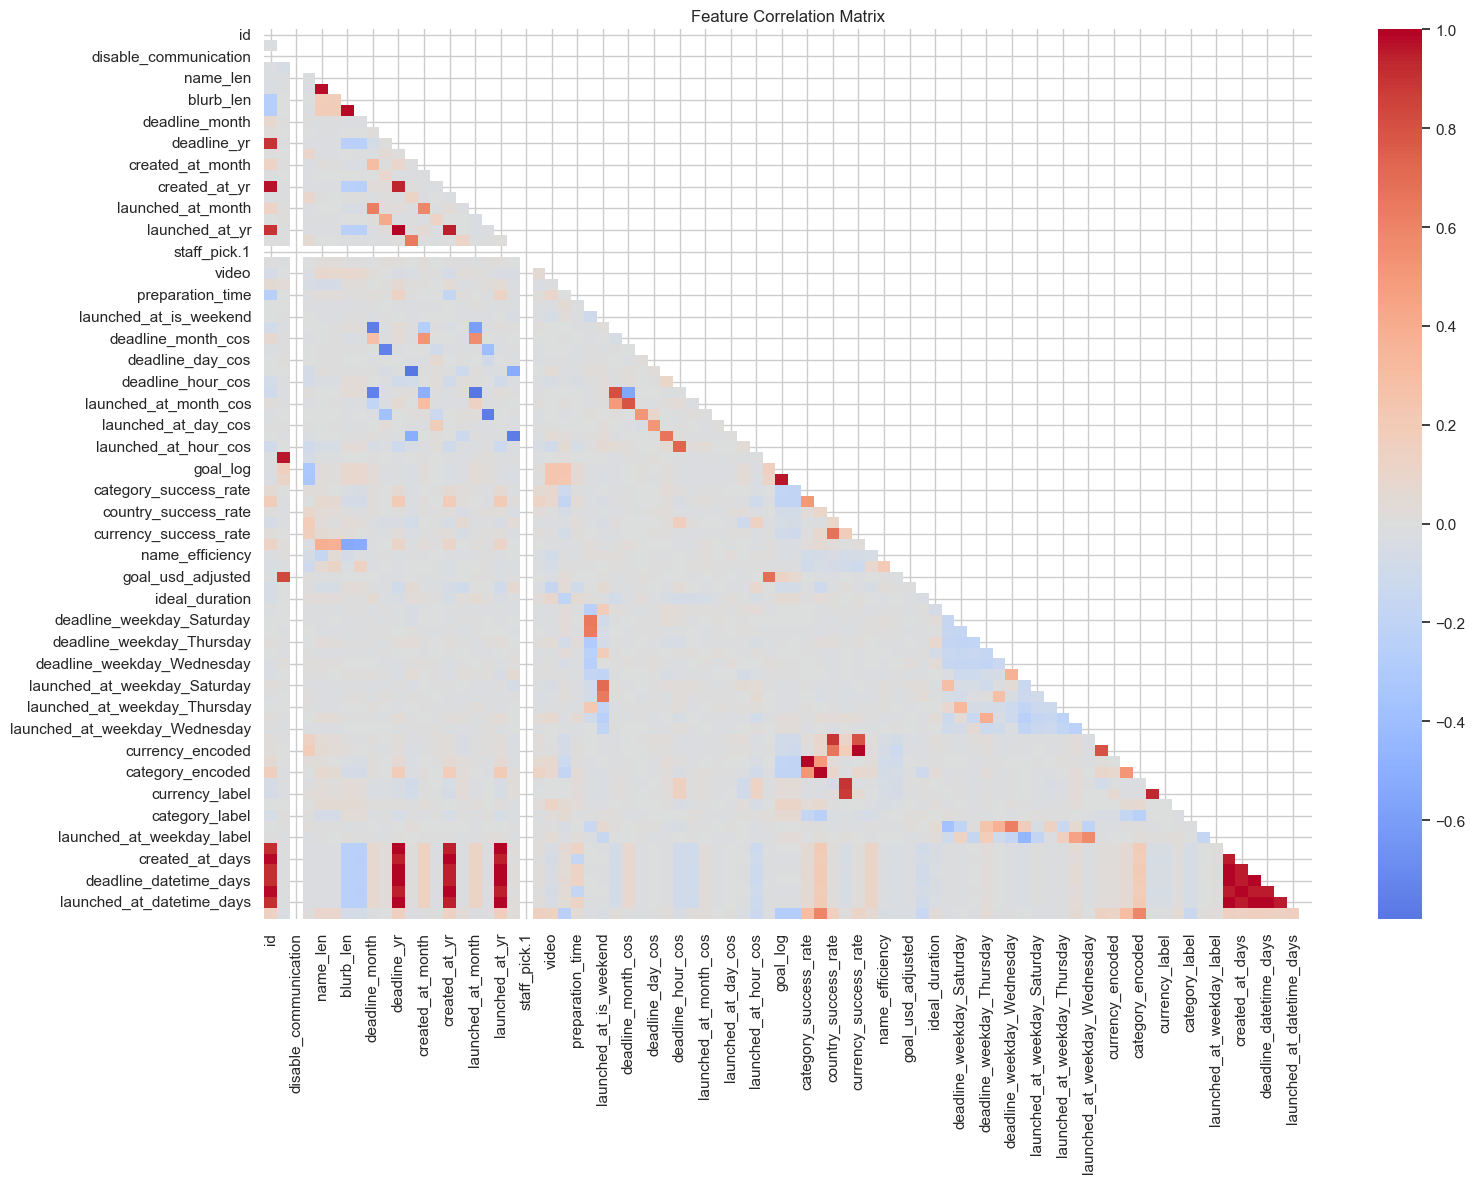


Top 10 features correlated with target:
subcategory_success_rate     0.594506
category_encoded             0.589469
category_success_rate        0.303543
main_category_encoded        0.301110
launched_at_yr               0.165043
launched_at_datetime_days    0.160799
launched_at_days             0.160799
show_feature_image           0.158846
country_success_rate         0.157278
deadline_yr                  0.157189
Name: target, dtype: float64

Bottom 10 features correlated with target:
staff_pick.1                  NaN
disable_communication         NaN
goal_log                -0.271310
goal_percentile_bin     -0.270997
campaign_duration       -0.230113
same_day_launch         -0.144357
category_label          -0.136741
launched_at_hour_cos    -0.126140
blurb_len_clean         -0.068499
blurb_len               -0.062485
Name: target, dtype: float64

Found 30 features with correlation > 0.7 to other features:
- launched_at_month_sin (correlated with: deadline_month_sin (0.816), launch

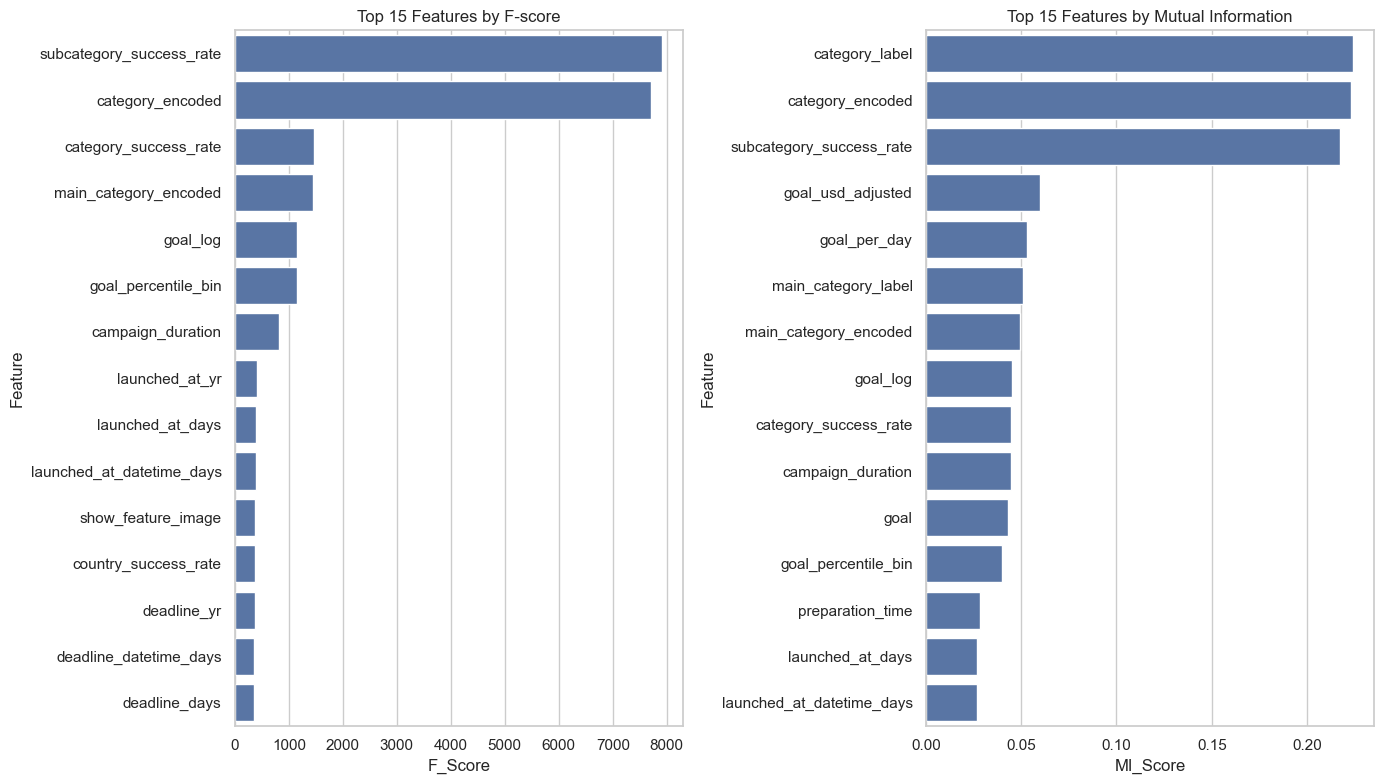


Number of common features selected by both methods: 23

=== MODEL-BASED FEATURE SELECTION ===


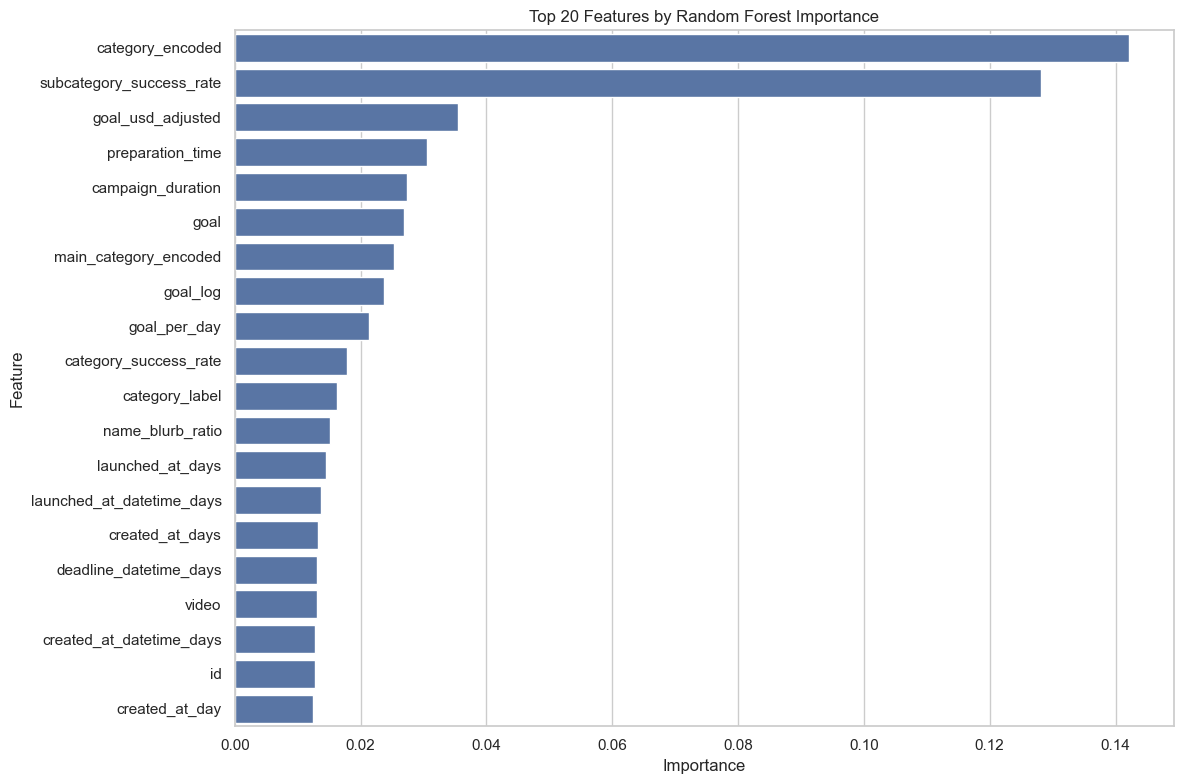


Top 15 features by Random Forest importance:
                      Feature  Importance
68           category_encoded    0.142183
43   subcategory_success_rate    0.128097
50          goal_usd_adjusted    0.035439
24           preparation_time    0.030535
23          campaign_duration    0.027382
1                        goal    0.026945
67      main_category_encoded    0.025284
40                   goal_log    0.023667
39               goal_per_day    0.021350
42      category_success_rate    0.017892
72             category_label    0.016183
47           name_blurb_ratio    0.015152
77           launched_at_days    0.014417
80  launched_at_datetime_days    0.013704
76            created_at_days    0.013210

Selected 37 features with cumulative importance > 0.8

Random Forest model with selected features - AUC: 0.8883
(Compared to full feature set AUC: 0.8902)

=== RECURSIVE FEATURE ELIMINATION ===
Performing recursive feature elimination with cross-validation...


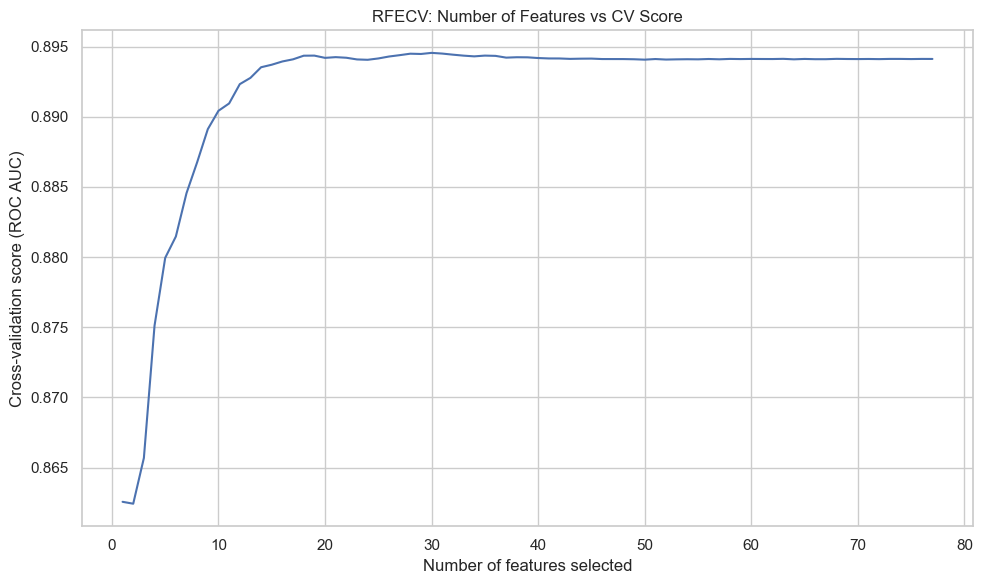


RFECV selected 34 features with optimal CV score: 0.8943

RFECV selected features:
- goal
- static_usd_rate
- name_len
- name_len_clean
- blurb_len_clean
- created_at_hr
- launched_at_month
- launched_at_yr
- launched_at_hr
- show_feature_image
- video
- campaign_duration
- deadline_hour_sin
- deadline_hour_cos
- launched_at_hour_sin
- launched_at_hour_cos
- goal_log
- goal_percentile_bin
- category_success_rate
- subcategory_success_rate
- country_success_rate
- currency_success_rate
- name_blurb_ratio
- name_efficiency
- goal_usd_adjusted
- same_day_launch
- country_encoded
- currency_encoded
- main_category_encoded
- category_encoded
- country_label
- currency_label
- main_category_label
- launched_at_weekday_label

=== ENSEMBLE FEATURE SELECTION ===


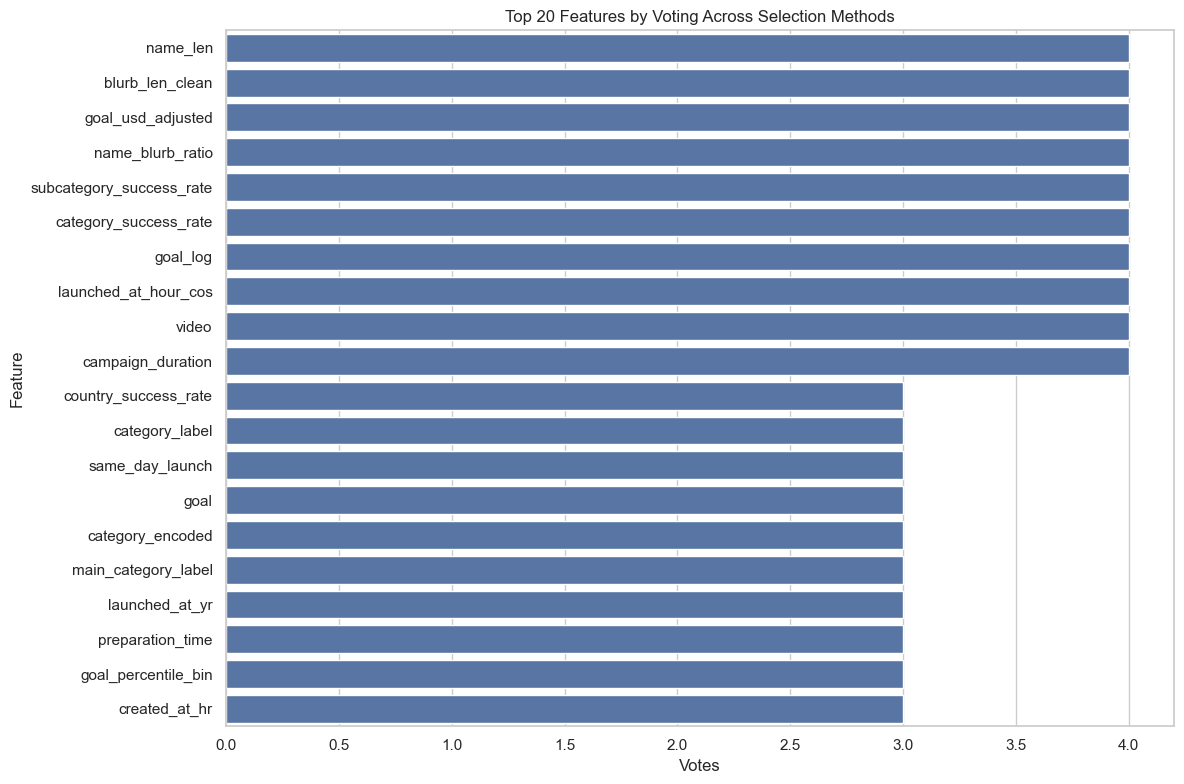


Ensemble selection chose 50 features that appear in at least 2 selection methods

Top 15 features by voting:
                     Feature  Votes
2                   name_len      4
3            blurb_len_clean      4
33         goal_usd_adjusted      4
30          name_blurb_ratio      4
27  subcategory_success_rate      4
26     category_success_rate      4
25                  goal_log      4
24      launched_at_hour_cos      4
12                     video      4
13         campaign_duration      4
28      country_success_rate      3
48            category_label      3
34           same_day_launch      3
57                      goal      3
59          category_encoded      3

=== EVALUATING FEATURE SUBSETS ===

Evaluating correlation feature set (51 features)...
  AUC: 0.8911

Evaluating anova_f feature set (30 features)...
  AUC: 0.8885

Evaluating mutual_info feature set (30 features)...
  AUC: 0.8908

Evaluating random_forest feature set (37 features)...
  AUC: 0.8883

Evaluating 

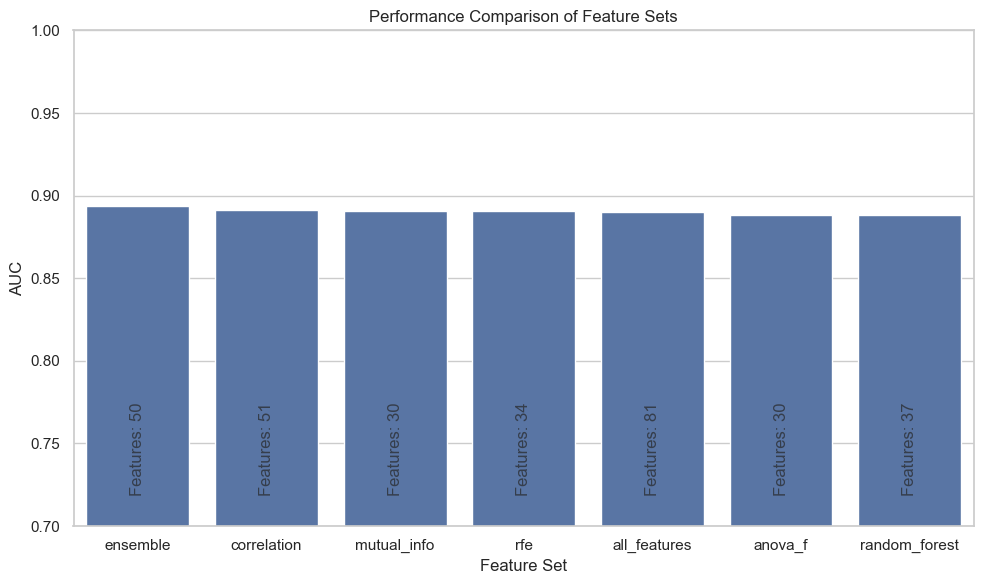


Feature set performance summary:
     Feature Set  Number of Features       AUC
5       ensemble                  50  0.893784
0    correlation                  51  0.891136
2    mutual_info                  30  0.890765
4            rfe                  34  0.890615
6   all_features                  81  0.890166
1        anova_f                  30  0.888478
3  random_forest                  37  0.888299

Best performing feature set: ensemble with AUC: 0.8938

Saved 50 selected features to 'selected_features.txt'


In [33]:
"""
Kickstarter Project: Feature Selection

This script focuses on advanced feature selection techniques for the Kickstarter dataset:
1. Correlation-based selection
2. Statistical feature selection methods
3. Model-based feature importance
4. Recursive feature elimination

The goal is to identify the most relevant features for predicting Kickstarter project success.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set visual style
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def load_preprocessed_data(file_path):
    """
    Load the preprocessed Kickstarter data
    """
    print(f"Loading preprocessed data from {file_path}...")
    try:
        # Assuming the preprocessed data is saved as CSV or Excel
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        else:
            df = pd.read_excel(file_path)
        
        print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        # For demo purposes, we'll load the raw data and do basic preprocessing
        print("Falling back to raw data and performing basic preprocessing...")
        raw_df = pd.read_excel("Kickstarter.xlsx")
        raw_df = raw_df[raw_df['state'].isin(['successful', 'failed'])]
        raw_df['target'] = (raw_df['state'] == 'successful').astype(int)
        return raw_df

def identify_numeric_categorical(df, target_col='target'):
    """
    Identify numeric and categorical columns in the dataset
    """
    # Drop the target column
    features_df = df.drop(columns=[target_col])
    
    # Identify numeric and categorical columns
    numeric_cols = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = features_df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
    
    print(f"Identified {len(numeric_cols)} numeric columns and {len(categorical_cols)} categorical columns")
    return numeric_cols, categorical_cols

def correlation_based_selection(df, numeric_cols, target_col='target', threshold=0.7):
    """
    Perform correlation-based feature selection
    
    Parameters:
    df (pd.DataFrame): DataFrame with features and target
    numeric_cols (list): List of numeric columns
    target_col (str): Name of target column
    threshold (float): Correlation threshold for feature removal
    
    Returns:
    list: List of selected features
    """
    print("\n=== CORRELATION-BASED SELECTION ===")
    
    # Make sure target_col is included for correlation calculation
    correlation_columns = numeric_cols + [target_col]
    correlation_df = df[correlation_columns]
    
    # Calculate correlation matrix
    correlation_matrix = correlation_df.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(16, 12))
    mask = np.zeros_like(correlation_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=False, center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Identify features correlated with target
    target_correlation = correlation_matrix[target_col].sort_values(ascending=False)
    print("\nTop 10 features correlated with target:")
    print(target_correlation[1:11])  # Exclude the target's correlation with itself
    
    print("\nBottom 10 features correlated with target:")
    print(target_correlation[:-11:-1])  # Get the last 10 excluding target
    
    # Function to find highly correlated features
    def find_correlated_features(correlation_matrix, threshold):
        correlated_features = set()
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                col_i = correlation_matrix.columns[i]
                col_j = correlation_matrix.columns[j]
                # Skip if either column is the target
                if col_i == target_col or col_j == target_col:
                    continue
                # Check if correlation exceeds threshold
                if abs(correlation_matrix.iloc[i, j]) > threshold:
                    # Keep the feature with higher correlation to target
                    if abs(correlation_matrix[target_col][col_i]) < abs(correlation_matrix[target_col][col_j]):
                        correlated_features.add(col_i)
                    else:
                        correlated_features.add(col_j)
        return correlated_features
    
    # Find highly correlated features
    correlated_features = find_correlated_features(correlation_matrix, threshold)
    
    print(f"\nFound {len(correlated_features)} features with correlation > {threshold} to other features:")
    for feature in correlated_features:
        # Find which feature(s) this is correlated with
        correlated_with = []
        for col in correlation_matrix.columns:
            if col != feature and col != target_col and abs(correlation_matrix[feature][col]) > threshold:
                correlated_with.append((col, correlation_matrix[feature][col]))
        
        # Sort by correlation strength
        correlated_with.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Print the feature and its correlations
        corr_str = ", ".join([f"{col} ({corr:.3f})" for col, corr in correlated_with[:3]])
        print(f"- {feature} (correlated with: {corr_str}...)")
    
    # Select features by removing highly correlated ones
    selected_features = [col for col in numeric_cols if col not in correlated_features]
    
    print(f"\nSelected {len(selected_features)} features after correlation-based selection")
    return selected_features

def statistical_feature_selection(df, numeric_cols, target_col='target'):
    """
    Perform statistical feature selection using various methods
    
    Parameters:
    df (pd.DataFrame): DataFrame with features and target
    numeric_cols (list): List of numeric columns
    target_col (str): Name of target column
    
    Returns:
    dict: Dictionary of selected features by different methods
    """
    print("\n=== STATISTICAL FEATURE SELECTION ===")
    
    # Extract features and target
    X = df[numeric_cols]
    y = df[target_col]
    
    # Scale features for better performance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize results dictionary
    selected_features = {}
    
    # 1. ANOVA F-value selection
    print("\nPerforming ANOVA F-value selection...")
    k_best_f = min(30, len(numeric_cols))  # Select top 30 features or all if fewer
    f_selector = SelectKBest(f_classif, k=k_best_f)
    f_selector.fit(X_scaled, y)
    
    # Get feature scores and p-values
    f_scores = pd.DataFrame({
        'Feature': numeric_cols,
        'F_Score': f_selector.scores_,
        'P_Value': f_selector.pvalues_
    })
    f_scores = f_scores.sort_values('F_Score', ascending=False)
    
    # Print top features
    print("\nTop 10 features by F-score:")
    print(f_scores.head(10))
    
    # Store selected features
    f_selected = [numeric_cols[i] for i in range(len(numeric_cols)) if f_selector.get_support()[i]]
    selected_features['anova_f'] = f_selected
    
    # 2. Mutual Information selection
    print("\nPerforming Mutual Information selection...")
    k_best_mi = min(30, len(numeric_cols))
    mi_selector = SelectKBest(mutual_info_classif, k=k_best_mi)
    mi_selector.fit(X_scaled, y)
    
    # Get feature scores
    mi_scores = pd.DataFrame({
        'Feature': numeric_cols,
        'MI_Score': mi_selector.scores_
    })
    mi_scores = mi_scores.sort_values('MI_Score', ascending=False)
    
    # Print top features
    print("\nTop 10 features by Mutual Information score:")
    print(mi_scores.head(10))
    
    # Store selected features
    mi_selected = [numeric_cols[i] for i in range(len(numeric_cols)) if mi_selector.get_support()[i]]
    selected_features['mutual_info'] = mi_selected
    
    # Visualize the top features from both methods
    plt.figure(figsize=(14, 8))
    
    # Plot F-scores
    plt.subplot(1, 2, 1)
    sns.barplot(x='F_Score', y='Feature', data=f_scores.head(15))
    plt.title('Top 15 Features by F-score')
    plt.tight_layout()
    
    # Plot MI scores
    plt.subplot(1, 2, 2)
    sns.barplot(x='MI_Score', y='Feature', data=mi_scores.head(15))
    plt.title('Top 15 Features by Mutual Information')
    plt.tight_layout()
    
    plt.show()
    
    # Compare the selected features from both methods
    common_features = set(f_selected).intersection(set(mi_selected))
    print(f"\nNumber of common features selected by both methods: {len(common_features)}")
    
    return selected_features

def model_based_feature_selection(df, numeric_cols, target_col='target'):
    """
    Perform model-based feature selection using Random Forest importance
    
    Parameters:
    df (pd.DataFrame): DataFrame with features and target
    numeric_cols (list): List of numeric columns
    target_col (str): Name of target column
    
    Returns:
    list: List of important features selected by the model
    """
    print("\n=== MODEL-BASED FEATURE SELECTION ===")
    
    # Extract features and target
    X = df[numeric_cols]
    y = df[target_col]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train a Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Get feature importances
    importances = rf.feature_importances_
    
    # Create DataFrame with feature importances
    feature_importance = pd.DataFrame({
        'Feature': numeric_cols,
        'Importance': importances
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Features by Random Forest Importance')
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("\nTop 15 features by Random Forest importance:")
    print(feature_importance.head(15))
    
    # Select top features (cumulative importance > 0.8)
    cumulative_importance = 0
    selected_features = []
    
    for i, row in feature_importance.iterrows():
        cumulative_importance += row['Importance']
        selected_features.append(row['Feature'])
        if cumulative_importance > 0.8:
            break
    
    print(f"\nSelected {len(selected_features)} features with cumulative importance > 0.8")
    
    # Evaluate model with selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    rf_selected = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_selected.fit(X_train_selected, y_train)
    
    # Get performance metrics
    y_pred_proba = rf_selected.predict_proba(X_test_selected)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\nRandom Forest model with selected features - AUC: {auc_score:.4f}")
    print(f"(Compared to full feature set AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]):.4f})")
    
    return selected_features

def recursive_feature_elimination(df, numeric_cols, target_col='target'):
    """
    Perform Recursive Feature Elimination with Cross-Validation
    
    Parameters:
    df (pd.DataFrame): DataFrame with features and target
    numeric_cols (list): List of numeric columns
    target_col (str): Name of target column
    
    Returns:
    list: List of features selected by RFE
    """
    print("\n=== RECURSIVE FEATURE ELIMINATION ===")
    
    # Extract features and target
    X = df[numeric_cols]
    y = df[target_col]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Initialize base estimator (logistic regression with L1 penalty)
    estimator = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
    
    # Initialize RFE with cross-validation
    rfecv = RFECV(
        estimator=estimator,
        step=1,
        cv=StratifiedKFold(5, shuffle=True, random_state=42),
        scoring='roc_auc',
        min_features_to_select=5,
        n_jobs=-1
    )
    
    # Fit RFE
    print("Performing recursive feature elimination with cross-validation...")
    rfecv.fit(X_scaled, y)
    
    # Get CV scores (compatible with both older and newer scikit-learn)
    try:
        # For older scikit-learn versions
        cv_scores = rfecv.grid_scores_
    except AttributeError:
        # For newer scikit-learn versions
        cv_scores = rfecv.cv_results_['mean_test_score']
    
    # Plot number of features vs. cross-validation scores
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation score (ROC AUC)")
    plt.plot(range(1, len(cv_scores) + 1), cv_scores)
    plt.title('RFECV: Number of Features vs CV Score')
    plt.tight_layout()
    plt.show()
    
    # Get selected features
    selected_features = [feature for feature, selected in zip(numeric_cols, rfecv.support_) if selected]
    
    # Get optimal score (compatible with both versions)
    optimal_score = cv_scores[rfecv.n_features_ - 1]
    
    print(f"\nRFECV selected {len(selected_features)} features with optimal CV score: {optimal_score:.4f}")
    print("\nRFECV selected features:")
    for feature in selected_features:
        print(f"- {feature}")
    
    return selected_features
    

def ensemble_feature_selection(correlation_selected, statistical_selected, rf_selected, rfe_selected):
    """
    Combine results from different feature selection methods
    
    Parameters:
    correlation_selected (list): Features selected by correlation-based method
    statistical_selected (dict): Features selected by statistical methods
    rf_selected (list): Features selected by Random Forest
    rfe_selected (list): Features selected by RFE
    
    Returns:
    list: Ensemble of selected features
    """
    print("\n=== ENSEMBLE FEATURE SELECTION ===")
    
    # Combine features from statistical methods
    all_statistical = set(statistical_selected['anova_f'] + statistical_selected['mutual_info'])
    
    # Count occurences of each feature across methods
    feature_counts = {}
    
    # Add correlation-based features
    for feature in correlation_selected:
        feature_counts[feature] = feature_counts.get(feature, 0) + 1
    
    # Add statistical features
    for feature in all_statistical:
        feature_counts[feature] = feature_counts.get(feature, 0) + 1
    
    # Add Random Forest features
    for feature in rf_selected:
        feature_counts[feature] = feature_counts.get(feature, 0) + 1
    
    # Add RFE features
    for feature in rfe_selected:
        feature_counts[feature] = feature_counts.get(feature, 0) + 1
    
    # Create DataFrame to display feature counts
    feature_votes = pd.DataFrame({
        'Feature': list(feature_counts.keys()),
        'Votes': list(feature_counts.values())
    })
    feature_votes = feature_votes.sort_values('Votes', ascending=False)
    
    # Plot feature votes
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Votes', y='Feature', data=feature_votes.head(20))
    plt.title('Top 20 Features by Voting Across Selection Methods')
    plt.tight_layout()
    plt.show()
    
    # Select features that appear in at least 2 methods
    ensemble_selected = [feature for feature, count in feature_counts.items() if count >= 2]
    
    print(f"\nEnsemble selection chose {len(ensemble_selected)} features that appear in at least 2 selection methods")
    print("\nTop 15 features by voting:")
    print(feature_votes.head(15))
    
    return ensemble_selected

def evaluate_feature_subsets(df, feature_sets, target_col='target'):
    """
    Evaluate different feature subsets using Random Forest
    
    Parameters:
    df (pd.DataFrame): DataFrame with features and target
    feature_sets (dict): Dictionary of feature sets to evaluate
    target_col (str): Name of target column
    
    Returns:
    dict: Performance metrics for each feature set
    """
    print("\n=== EVALUATING FEATURE SUBSETS ===")
    
    # Extract target
    y = df[target_col]
    
    # Initialize results dictionary
    results = {}
    
    # Split data once for fair comparison
    indices = np.arange(len(df))
    train_indices, test_indices = train_test_split(
        indices, test_size=0.2, random_state=42, stratify=y
    )
    
    # Evaluate each feature set
    for name, features in feature_sets.items():
        print(f"\nEvaluating {name} feature set ({len(features)} features)...")
        
        # Extract features
        X = df[features]
        
        # Split into train and test
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
        # Train Random Forest model
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = rf.predict_proba(X_test)[:, 1]
        
        # Calculate AUC
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store results
        results[name] = {
            'num_features': len(features),
            'auc': auc
        }
        
        print(f"  AUC: {auc:.4f}")
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'Feature Set': list(results.keys()),
        'Number of Features': [results[k]['num_features'] for k in results.keys()],
        'AUC': [results[k]['auc'] for k in results.keys()]
    })
    
    # Sort by AUC
    summary = summary.sort_values('AUC', ascending=False)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feature Set', y='AUC', data=summary)
    plt.title('Performance Comparison of Feature Sets')
    plt.ylim(0.7, 1.0)
    for i, row in enumerate(summary.itertuples()):
        plt.text(i, 0.72, f"Features: {row._2}", ha='center', rotation=90, alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print("\nFeature set performance summary:")
    print(summary)
    
    # Return the best feature set
    best_set = summary.iloc[0]['Feature Set']
    print(f"\nBest performing feature set: {best_set} with AUC: {summary.iloc[0]['AUC']:.4f}")
    
    return feature_sets[best_set], results

def main():
    """
    Main function to run the feature selection process
    """
    # Load preprocessed data
    df_clean = load_preprocessed_data("/Users/jaeyoonlee/Desktop/kickstarter_processed.csv")
    
    # Check if target column exists, otherwise create it
    if 'target' not in df_clean.columns and 'state' in df_clean.columns:
        df_clean['target'] = (df_clean['state'] == 'successful').astype(int)
    
    # Identify numeric and categorical columns
    numeric_cols, categorical_cols = identify_numeric_categorical(df_clean)
    
    # Only keep numeric columns for now
    df_numeric = df_clean[numeric_cols + ['target']]
    
    # 1. Correlation-based selection
    correlation_selected = correlation_based_selection(df_numeric, numeric_cols)
    
    # 2. Statistical feature selection
    statistical_selected = statistical_feature_selection(df_numeric, numeric_cols)
    
    # 3. Model-based selection
    rf_selected = model_based_feature_selection(df_numeric, numeric_cols)
    
    # 4. Recursive feature elimination
    rfe_selected = recursive_feature_elimination(df_numeric, numeric_cols)
    
    # 5. Ensemble selection
    ensemble_selected = ensemble_feature_selection(
        correlation_selected, statistical_selected, rf_selected, rfe_selected
    )
    
    # Evaluate all feature sets
    feature_sets = {
        'correlation': correlation_selected,
        'anova_f': statistical_selected['anova_f'],
        'mutual_info': statistical_selected['mutual_info'],
        'random_forest': rf_selected,
        'rfe': rfe_selected,
        'ensemble': ensemble_selected,
        'all_features': numeric_cols
    }
    
    best_features, results = evaluate_feature_subsets(df_numeric, feature_sets)
    
    # Save selected features for model training
    with open('"/Users/jaeyoonlee/Desktop/selected_features.txt"', 'w') as f:
        for feature in best_features:
            f.write(f"{feature}\n")
    
    print(f"\nSaved {len(best_features)} selected features to 'selected_features.txt'")

if __name__ == "__main__":
    main()